In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from capytaine_generator import CapytaineSlantSolver
from matplotlib.ticker import ScalarFormatter

try:
    from openflash import *
    from openflash.multi_equations import *
    from openflash.multi_constants import g
    print("OpenFLASH modules imported successfully!")
except ImportError as e:
    print(f"Error importing OpenFLASH modules. Error: {e}")

# Set NumPy print options for better readability
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)

import sys
from pathlib import Path
HERE = Path.cwd().resolve()
store_path_prefix = str((HERE / "data").resolve())
store_path_str = store_path_prefix + "/slants.pkl"

low_m0_dir = (HERE / ".." / "dev" / "python" / "limiting-cases").resolve()
if str(low_m0_dir) not in sys.path:
    sys.path.insert(0, str(low_m0_dir))
from low_m0 import low_get_hydros

utils_path = (HERE / ".." / "sea-lab-utils").resolve()
utils_str = str(utils_path)
if utils_str not in sys.path:
    sys.path.insert(0, utils_str)
from pyplotutilities import colors # Assuming 'pyplotutilities' is a folder inside 'sea-lab-utils'
from pyplotutilities import fonts
colors.get_colors()
fonts.get_fonts()
print(colors.purple)

figs_path_prefix = str((HERE / ".." / "pubs/JFM/figs").resolve())

import warnings
warnings.filterwarnings("ignore") # Inelegant, but gets rid of LinAlgWarnings


OpenFLASH modules imported successfully!
#CC79A7


In [2]:
# Variable Definitions
h = 50.00 # sea depth [m]
d_list = [14.45, 14.45-7.32-5.08] # drafts [m]
a_list = [2.5/2, 8.4/2] # radii [m]
# h, d_list, a_list = 2, [1, 0.5], [0.5, 1]
minexp = -3
exponents = np.linspace(minexp, 3, 121)
omega_sweep = np.array(list(10**exponents)+ [np.inf])
low_omegas = np.array(list(10**np.linspace(minexp, 0, 61)))
low_m0s = [wavenumber(omega, h) for omega in low_omegas]
NMK = [100, 100, 100] # number of coefficients in each region
heaving = [1, 1]

In [3]:
# Regular MEEM
def x_collector(reformatted, nmk1):
    dict1 = {("C11" + str(i)) : reformatted[1][i] for i in range (4)}
    dict2 = {("C12" + str(i)) : reformatted[1][nmk1 + i] for i in range (4)}
    return {**dict1, **dict2}

def get_MEEM_hydros(h, omega_sweep, d_list, a_list, NMK):
    A_MEEM = np.zeros_like(omega_sweep)
    B_MEEM = np.zeros_like(omega_sweep)
    x_collective = []

    body = SteppedBody(a=np.array(a_list), d=np.array(d_list), slant_angle= np.zeros_like(a_list), heaving=True)
    arrangement = ConcentricBodyGroup([body])
    geometry = BasicRegionGeometry(body_arrangement=arrangement, h=h, NMK=NMK)
    problem = MEEMProblem(geometry)
    problem.set_frequencies(omega_sweep)
    engine = MEEMEngine(problem_list=[problem])
    for j in range(len(omega_sweep)):
        m0 = wavenumber(omega_sweep[j], h)
        X = engine.solve_linear_system_multi(problem, m0)
        reformatted = engine.reformat_coeffs(X, NMK, len(a_list))
        x_collective.append(x_collector(reformatted, NMK[1]))
        coeffs = engine.compute_hydrodynamic_coefficients(problem, X, m0)
        A_MEEM[j] = coeffs[0]['real']
        B_MEEM[j] = coeffs[0]['imag']

    return A_MEEM, B_MEEM, x_collective

In [4]:
added_masses, radiation_dampings, x_collective = get_MEEM_hydros(h, omega_sweep, d_list, a_list, NMK)
low_added_masses, low_radiation_dampings = low_get_hydros(h, d_list, a_list, heaving, low_m0s)

In [5]:
# Plot Settings
l_width = 3 # line width
m_size = 7 # marker size
lab_fs = 11 # x and y label font size
leg_fs = lab_fs * 0.9  # legend font size
fig_h = 6 # figure height
fig_w = 5 # figure width

In [6]:
# Geometry image functions
css = CapytaineSlantSolver(False, False, False, False, False)

# Function for getting coordinates of WEC geometry
def get_scaled_geom(a_list, d_in, d_out):

    RHS_coords = css.get_points(a_list, d_in, d_out)
    x_coords, y_coords = map(np.array, zip(*RHS_coords))

    x_undeformed = np.concatenate([-x_coords[::-1], x_coords])
    y_undeformed = np.concatenate([y_coords[::-1], y_coords])

    
    return x_undeformed, y_undeformed

def plot_geom(ax, a_list, d_in, d_out, x0, x_width):
  x_undeformed, y_undeformed = get_scaled_geom(a_list, d_in, d_out)
  y_height = max(d_in)/(2 * a_list[-1]) * x_width
  y0 = 0.97 - y_height
  ax_ins = ax.inset_axes([x0, y0, x_width, y_height])
  ax_ins.fill(x_undeformed, y_undeformed, color=[0.7,0.7,0.7], edgecolor='black')
  ax_ins.set_aspect('equal')
  ax_ins.set_xticks([])
  ax_ins.set_yticks([])
  ax_ins.axis('off') 

In [ ]:
def standard_subplot(omega_sweep, low_omegas, hydros, low_hydros, ax):
  hydro_inf = hydros[-1]
  ax.plot(omega_sweep[:-1], hydros[:-1],
          linestyle='-', color=colors.green, label='Standard MEEM', 
          linewidth=l_width-1.5, zorder=2)
  ax.plot(low_omegas, low_hydros,
          linestyle='--', color=colors.orange, label=r'Low $\omega$ Approximation', 
          linewidth=l_width-1.5, zorder=3)
  ax.axhline(hydro_inf, linestyle="--", linewidth=l_width-1,
             color = colors.blue, label = r"$\omega = \infty$", zorder=1)

def x_vector_subplot(omega_sweep, index_min, index_max, x_collective, ax, real = True):
  x_range = omega_sweep[index_min:index_max]
  all_colors = [colors.green, colors.skyblue, colors.blue, colors.purple]
  for i in range(4):
    subscript = "1" + str(i)
    complex_y_vals = [x_collective[j]["C1" + subscript] for j in range(index_min, index_max)]
    if real: y_vals = [entry.real for entry in complex_y_vals]
    else: y_vals = [entry.imag for entry in complex_y_vals]
    ax.plot(x_range, y_vals, linestyle = "-", color=all_colors[i],
            label = rf"$C^{{i_2}}_{{{subscript}}}$", linewidth=l_width-1.5, zorder=4-i)
    ax.grid(visible = "true", which="major", alpha = 0.4)

def plot_and_save_hydros(omega_sweep, low_omegas, ams, dps, low_ams, low_dps,
                         a_list, d_in, d_out, x_collective):
  fig, ax = plt.subplot_mosaic([["TL","TR"],["BL","BR"]], figsize=(1.6 * fig_h, fig_w),
                               gridspec_kw={"width_ratios": [1, 0.8]})
  ax["BL"].sharex(ax["TL"])
  ax["BR"].sharex(ax["TR"])
  ax["TL"].tick_params(labelbottom=False)
  ax["TR"].tick_params(labelbottom=False)

  for a in ax:
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1)) 
    ax[a].yaxis.set_major_formatter(formatter)
  
  standard_subplot(omega_sweep, low_omegas, ams, low_ams, ax["TL"])
  standard_subplot(omega_sweep, low_omegas, dps, low_dps, ax["BL"])
  plot_geom(ax["BL"], a_list, d_in, d_out, 0.7, 0.35)
  ax["TL"].legend(loc='upper right', fontsize=leg_fs, frameon=False)

  ax["BL"].set_xlim([10**-3, 10**3])
  ax["TL"].set_ylim([0, 2.5e5])
  ax["BL"].set_ylim([-0.1e4, 5.5e4])
  ax["BL"].set_xscale("log", base = 10)
  ax["BL"].set_xlabel('Frequency [rad/s]', fontsize=lab_fs)
  ax["TL"].set_ylabel('Added Mass [Ns/m]', fontsize=lab_fs)
  ax["BL"].set_ylabel('Damping [Ns/m]', fontsize=lab_fs)

  x_vector_subplot(omega_sweep, 0, 81, x_collective, ax["TR"], real = True)
  x_vector_subplot(omega_sweep, 0, 81, x_collective, ax["BR"], real = False)
  ax["TR"].legend(loc='upper right', fontsize=leg_fs, frameon=True).set_zorder(5)
  ax["BR"].set_xlim([10**-3, 10**1])
  ax["BR"].set_xscale("log", base = 10)
  ax["BR"].set_xlabel('Frequency [rad/s]', fontsize=lab_fs)
  ax["TR"].set_ylabel(r"$\mathrm{Re}[C^{{i_2}}_{1n_2}]$", fontsize=lab_fs, labelpad=-2)
  ax["BR"].set_ylabel(r"$\mathrm{Im}[C^{{i_2}}_{1n_2}]$", fontsize=lab_fs, labelpad=-2)

  full_path = figs_path_prefix + "/MEEM-Low-Freq.pdf"
  fig.savefig(full_path, format='pdf', dpi=300, bbox_inches='tight')

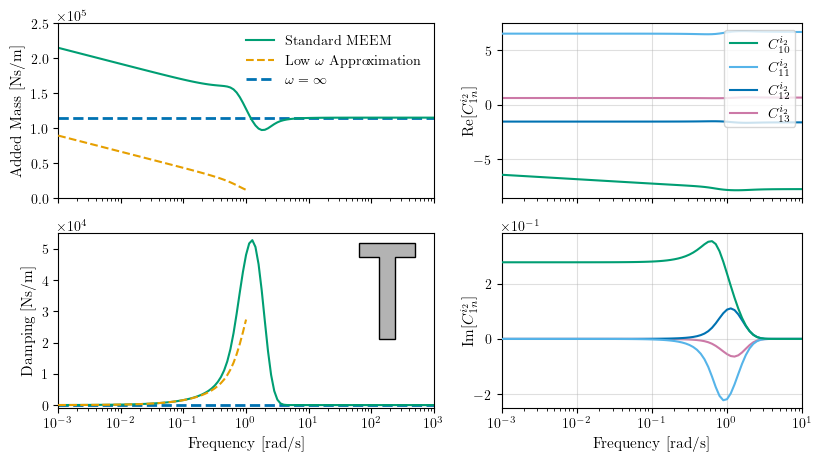

In [22]:
plot_and_save_hydros(omega_sweep, low_omegas,
                     added_masses, radiation_dampings,
                     low_added_masses, low_radiation_dampings,
                     a_list, d_list, d_list, x_collective)